# Consider the Decision Tree

> Understand the core strengths and weaknesses of the decision tree, and see how ensembling makes trees shine.

- toc: false
- badges: true
- comments: true
- categories: [gradient boosting]
- hide: false
- image: images/20211212_thumbnail.jpg


![](nb_images/20211212_thumbnail.jpg "A California cypress tree abides in silence on Alameda Beach.")

Ah, the decision tree. 

It's an underrated and often overlooked hero of modern statistical learning.
Trees aren't particularly powerful learning algorithms on their own, but when utilized as building blocks in larger ensemble models like random forest and gradient boosted trees, they can achieve state of the art performance in many practical applications.
So since we've been focusing on gradient boosted trees lately, I think it's high time for us to take a moment to recognize the unsung hero upon which our favorite tree ensemble method is typically based.

In this post we will
- Learn what decision trees are and see one in action.
- Discuss when trees are awesome.
- Discuss when trees are not so awesome.
- Find out how ensembling can magnify trees' strengths and mitigate their weaknesses.


## Classification and Regression Trees
Decision trees are statistical models that take features or covariates as input and yield a prediction as output. The idea of the decision tree as a statistical learning tool traces back to a monograph published in 1984 by Breiman, Freidman, Olshen, and Stone called "Classification and Regression Trees" (a.k.a. CART). As the name suggests, trees come in two main varieties: classification trees which predict discrete class labels (e.g. [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) and regression trees which predict numeric values (e.g. [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)).

As I mentioned earlier, tree models are not very powerful learners on their own. 
You might find that an individual tree model is useful for creating a simple and  highly interpretable model in specific situations, but in general, trees tend to shine most as building blocks in more complex algorithms.
These composite models are called ensembles, and the most important tree ensembles are random forest and gradient boosted trees. 
While random forest uses either regression or classification trees depending on the type of target, gradient boosting can use regression trees to solve both classification and regression tasks.  


## A Regression Tree in Action
Let's have a closer look at regression trees by  training one on the diabetes dataset from scikit learn. According to the [documentation](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset):

>> Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

First we load the data. To make our lives easier, we'll just use two features: average blood pressure  (bp) and the first blood serum measurement (s1) to predict the target. I'll also rescale the features (to make their values easier for me to read and type). Rescaling features won't affect our tree--one of the reasons trees are awesome (more on that later). 


In [35]:
#hide
%matplotlib inline

In [36]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color_palette = "viridis"

In [37]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(as_frame=True, return_X_y=True)

X = 100 * X[['bp', 's1']]

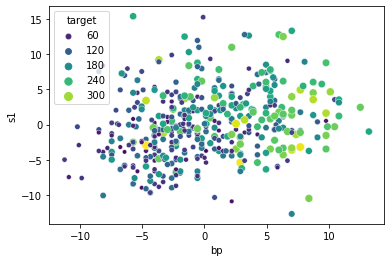

In [38]:
#hide_input
ax = sns.scatterplot(
    x=X.iloc[:, 0],
    y=X.iloc[:, 1],
    hue=y,
    size=y,
    palette=sns.color_palette(color_palette, as_cmap=True),
    legend='auto')
plt.sca(ax)

Let's grow a tree to predict the target given values of blood pressure and blood serum.  

In [39]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=2)
tree.fit(X,y);

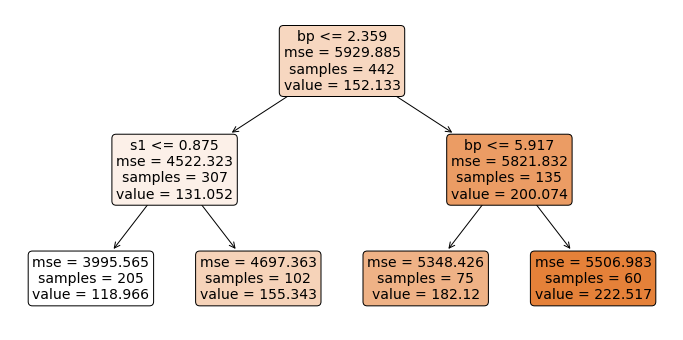

In [40]:
#hide_input
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(12,6))
plot_tree(tree,
         feature_names=X.columns,
         filled=True,
         rounded=True,
         fontsize=14);

To make predictions using our fitted tree, we start at the root node (which is at the top), and we work our way down moving left if our feature is less than the split threshold and to the right if it's greater than the split threshold. For example let's predict the target for a new case with bp= 1 and s1 = 5. Since our blood pressure of 1 is less than 2.359, we move to the left child node. Here, since our serum of 5 is greater than the threshold at 0.875, we move to the right child node. This node has no further children, and thus we return its predicted value of 155.343.


In [41]:
tree.predict(pd.DataFrame({'bp': 1, 's1': 5}, index=[0]))

array([155.34313725])

Let's overlay these splits on our feature scatterplot to see how the tree has partitioned the feature space.

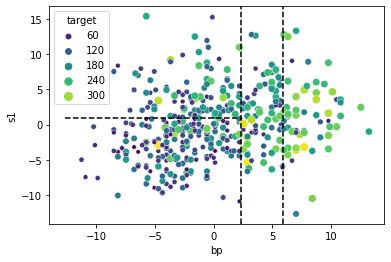

In [42]:
#hide_input
t = tree.tree_
id = 0
id_l = t.children_left[id]
id_r = t.children_right[id]
f_0 = t.feature[id]; cut_0 = t.threshold[id]
f_l = t.feature[id_l]; cut_l = t.threshold[id_l]
f_r = t.feature[id_r]; cut_r = t.threshold[id_r]

ax = sns.scatterplot(
    x=X.iloc[:, 0],
    y=X.iloc[:, 1],
    hue=y,
    size=y,
    palette=sns.color_palette(color_palette, as_cmap=True),
    legend='auto',)
plt.sca(ax);
plt.axvline(x=cut_0, color='black', linestyle='dashed')
plt.axvline(x=cut_r, color='black', linestyle='dashed')
plt.plot([X.iloc[:,1].min(), cut_0], [cut_l, cut_l], '--k');

The tree has managed to carve out regions of feature space where the target values tend to be similar within each region, e.g. we have low target values in the bottom left partition and high target values in the far right region.

Let's take a look at the regression surface predicted by our tree. Since the tree predicts the exact same value for all instances in a given partition, the surface has only four distinct values.


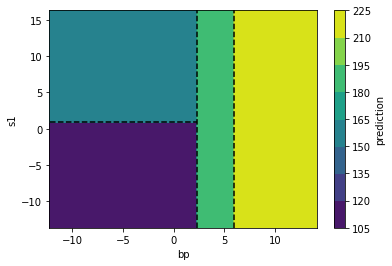

In [43]:
#hide_input
t = tree.tree_
id = 0
id_l = t.children_left[id]
id_r = t.children_right[id]
f_0 = t.feature[id]; cut_0 = t.threshold[id]
f_l = t.feature[id_l]; cut_l = t.threshold[id_l]
f_r = t.feature[id_r]; cut_r = t.threshold[id_r]

fig, ax = plt.subplots()

plt.sca(ax)
plt.axvline(x=cut_0, color='black', linestyle='dashed')
plt.axvline(x=cut_r, color='black', linestyle='dashed')
plt.plot([X.iloc[:,1].min()+0.5, cut_0], [cut_l, cut_l], '--k')

# define bounds of the domain
min1, max1 = X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1
min2, max2 = X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))
# make predictions for the grid
yhat = tree.predict(grid)
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='viridis')

cbar = plt.colorbar();
cbar.set_label('prediction')
plt.xlabel('bp')
plt.ylabel('s1');

Fabulous, now that we've seen a tree in action, let's talk about trees' key strengths and weaknesses.

## How trees are awesome
Trees are awesome because they are easy to use, and trees are easy to use because they are  robust, require minimal data preprocessing, and can learn complex relationships without user intervention.

### Feature Scaling and Shifting
Trees owe their minimal data preprocessing requirements and their robustness to the fact that split finding is based on feature value rank statistics. We'll go into detail about how the split finding algorithm works when we implement a decision tree from scratch in a future post, but for now, know that a tree will partition the feature space in exactly the same way regardless of how feature values are shifted or scaled. Another way to say this is that in the plots from the previous section, the tree would split the same way regardless of the axis labels. This means we can avoid the hassle of rescaling features. It also means that trees tend to work well even if features are highly skewed or contain outliers.

Here I fit a tree to four sets of data: $(x,y)$, $(ax, y)$, $(x+b, y)$, and  $(ax+b,y)$. In each case the transformations only change the labels on the $x$-axis, and we get the same splits and predicted values.

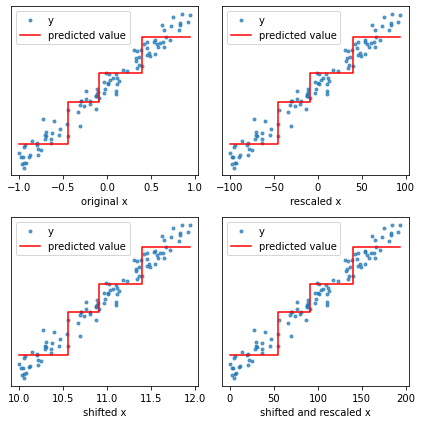

In [44]:
#hide_input
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(6,6))

rng = np.random.default_rng()
xx = np.sort(rng.uniform(-1,1,100))
# yx = np.sin(xx * 2 * np.pi * 0.5) + rng.normal(0, 0.2, xx.shape)
yx = xx + rng.normal(0, 0.1, xx.shape)
xx = xx.reshape(-1, 1)

def make_subplot(xx, ax, title):
    ex_tree = DecisionTreeRegressor(max_depth=2)
    ex_tree.fit(xx, yx)
    ex_tree_pred = ex_tree.predict(xx)

    plt.sca(ax)
    plt.plot(xx, yx, '.', alpha=0.7, label='y')
    plt.step(xx, ex_tree_pred, '-r', label='predicted value')
    plt.legend()
    # ax.get_xaxis().set_ticks([])
    plt.xlabel(title)
    ax.get_yaxis().set_ticks([])

make_subplot(xx, ax1, 'original x')
make_subplot(100*xx, ax2, 'rescaled x')
make_subplot(xx + 11, ax3, 'shifted x')
make_subplot(100*xx+100, ax4, 'shifted and rescaled x')

plt.tight_layout()

### Categoricals
Categorical features are relatively easy to handle, simply by using integer encoding. For example we might encode a size feature with small = 1, medium = 2, and large = 3.  This works particularly well with ordered categories, because partitioning is consistent with the category semantics. It can also work well even if the categories have no order, because with enough splits a tree can carve each category into its own partition.

### Missing Values
It's worth calling out that different implementations of the decision tree handle missing feature values in different ways. Notably, scikit-learn handles them by throwing an error and telling you not to pull such shenanigans. 

```
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').
```

On the other hand, XGBoost supports an elegant way to make use of missing values, which we will discuss more in a later post.

### Interactions
Feature interactions can also be learned automatically. An interaction means that the effect of one feature on the target differs depending on the value of another feature. For example, the effect of some drug may depend on whether or not the patient exercises. After a tree splits on exercise, it can naturally learn the correct drug effects for both exercisers and non-exercisers. This intuition extends to higher-order interactions as well, as long as the tree has enough splits to parse the relationships.

### Feature Selection
Because trees choose the best feature and threshold value at each split, they essentially perform automatic feature selection. This is great because even if we throw a lot of irrelevant features at a decision tree, it will simply tend not to use them for splits. Similarly, if two or more features are highly correlated or even redundant, the tree will simply choose one or the other when making each split; having both in the model will not cause catastrophic instability as it could in a linear model. 

### Feature-Target Relationship
Finally, it is possible for trees to discover complex feature-target relationships without the need for user-specification of the relationships. This is because trees use local piecewise constant approximations without making any parametric assumptions. With enough splits, the tree can approximate arbitrary feature-target relationships.


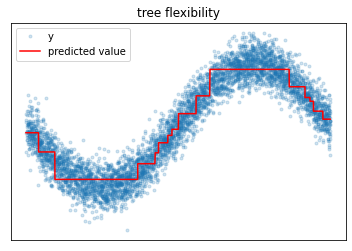

In [45]:
#hide_input
rng = np.random.default_rng()
xx = np.sort(rng.uniform(-1,1,5000))
yx = np.sin(xx * 2 * np.pi * 0.5) + rng.normal(0, 0.2, xx.shape)
xx = xx.reshape(-1, 1)
ex_tree = DecisionTreeRegressor(max_depth=4)
ex_tree.fit(xx, yx)
ex_tree_pred = ex_tree.predict(xx)
fig, ax = plt.subplots()
plt.plot(xx, yx, '.', alpha=0.2, label='y')
plt.plot(xx, ex_tree_pred, '-r', label='predicted value')
plt.legend()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.title('tree flexibility');

## How trees are not so awesome
The main weakness of the decision tree is that, on its own, it tends to have poor predictive performance compared to other algorithms. In my experience the main reasons for this are the tendency to overfit and prediction quantization issues.

### Overfitting
If we grow a decision tree until each leaf has exactly one instance in it, we will have simply memorized the training data, and our model will not generalize well. Basically the only defense against overfitting is to reduce the number of leaf nodes in the tree, either by using hyperparameters to stop splitting earlier or by removing certain leaf nodes after growing a deep tree.  The problem here is that some of the benefits of trees, like ability to approximate arbitrary target patterns and ability to learn interaction effects, depend on having enough splits for the task. We can sometimes find ourselves in a situation where we cannot learn these complex relationships without overfitting the tree.

### Quantization
Because regression trees use piecewise constant functions to approximate the target, prediction accuracy can deteriorate near split boundaries. For example, if the target is increasing with the feature, a tree might tend to overpredict the target on the left side of split boundaries and overpredict on the right side of split boundaries. 


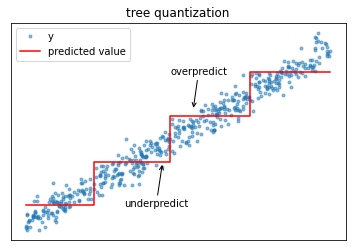

In [46]:
#hide_input
rng = np.random.default_rng()
xx = np.sort(rng.uniform(-1,1,500))
# yx = np.sin(xx * 2 * np.pi * 0.5) + rng.normal(0, 0.2, xx.shape)
yx = xx + rng.normal(0, 0.1, xx.shape)
xx = xx.reshape(-1, 1)
ex_tree = DecisionTreeRegressor(max_depth=2)
ex_tree.fit(xx, yx)
ex_tree_pred = ex_tree.predict(xx)
fig, ax = plt.subplots()
plt.plot(xx, yx, '.', alpha=0.5, label='y')
plt.step(xx, ex_tree_pred, '-r', label='predicted value')
plt.legend()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.annotate(text='overpredict', xy=(0.1, 0.3), xytext=(-0.05, 0.7), arrowprops={'arrowstyle': '->'})
plt.annotate(text='underpredict', xy=(-0.1, -0.3), xytext=(-0.35, -0.8), arrowprops={'arrowstyle': '->'})
plt.title('tree quantization');

### Extrapolation

Because they are trained by partitioning the feature space in a training dataset, trees cannot intelligently extrapolate beyond the data on which they are trained. For example if we query a tree for predictions beyond the greatest feature value encountered in training, it will just return the prediction corresponding to the largest in-sample feature values. 

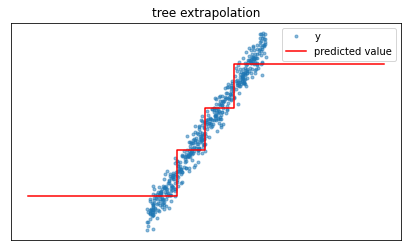

In [47]:
#hide_input
rng = np.random.default_rng()
xx = np.sort(rng.uniform(-1,1,500))
xx_test = np.sort(rng.uniform(-3,3,500))
# yx = np.sin(xx * 2 * np.pi * 0.5) + rng.normal(0, 0.2, xx.shape)
yx = xx + rng.normal(0, 0.1, xx.shape)
xx, xx_test = xx.reshape(-1, 1), xx_test.reshape(-1, 1)
ex_tree = DecisionTreeRegressor(max_depth=2)
ex_tree.fit(xx, yx)
ex_tree_pred = ex_tree.predict(xx_test)
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(xx, yx, '.', alpha=0.5, label='y')
plt.step(xx_test, ex_tree_pred, '-r', label='predicted value')
plt.legend()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
# plt.annotate(text='overpredict', xy=(0.1, 0.3), xytext=(-0.05, 0.7), arrowprops={'arrowstyle': '->'})
# plt.annotate(text='underpredict', xy=(-0.1, -0.3), xytext=(-0.35, -0.8), arrowprops={'arrowstyle': '->'})
plt.title('tree extrapolation');

###The Dark Side of Convenience
Finally, there is always a price to pay for convenience. While trees can work well even with a messy dataset containing outliers, redundant features, and thoughtlessly encoded categoricals, we will rarely achieve the best performance under these conditions. Taking the time to deal with outliers, removing redundant information, purposefully choosing appropriate categorical encodings, and building an understanding of the data will often lead to much better results. 


## How ensembling makes trees shine
We can go a long way toward addressing the issues of overfitting and prediction quantization by using trees as building blocks in larger algorithms called tree ensembles, the most popular examples being random forest and gradient boosted trees. A tree ensemble is a collection of different individual tree models whose predictions are averaged to generate an overall prediction. 

Ensembling helps address overfitting because even if each individual tree is overfitted, the average of their individual noisy predictions will tend to be more stable. Think of it in terms of the bias variance tradeoff, where variance refers to how different a model prediction would be if it were trained on a different sample of training data. Since the ensemble is averaging over the predictions of all the individual models, training it on a different sample of training data would change the individual models predictions, but not their overall average. Thus, ensembling helps reduce the effects of overfitting by reducing model variance.

Ensembling also helps address prediction quantization issues. While each individual tree's predictions might express large jumps in the regression surface, averaging many different trees' predictions together effectively generates a surface with more partitions and smaller jumps between them. This provides a smoother approximation of the feature-target relationship.


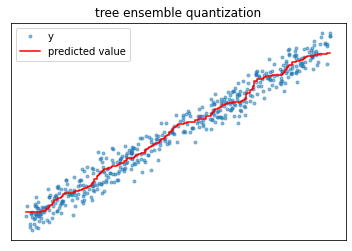

In [48]:
#hide_input
from sklearn.ensemble import RandomForestRegressor
rng = np.random.default_rng()
xx = np.sort(rng.uniform(-1,1,500))
# yx = np.sin(xx * 2 * np.pi * 0.5) + rng.normal(0, 0.2, xx.shape)
yx = xx + rng.normal(0, 0.1, xx.shape)
xx = xx.reshape(-1, 1)
ex_tree = RandomForestRegressor(n_estimators=100, max_depth=3, max_samples=0.2)
ex_tree.fit(xx, yx)
ex_tree_pred = ex_tree.predict(xx)
fig, ax = plt.subplots()
plt.plot(xx, yx, '.', alpha=0.5, label='y')
plt.step(xx, ex_tree_pred, '-r', label='predicted value')
plt.legend()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
# plt.annotate(text='overpredict', xy=(0.1, 0.3), xytext=(-0.05, 0.7), arrowprops={'arrowstyle': '->'})
# plt.annotate(text='underpredict', xy=(-0.1, -0.3), xytext=(-0.35, -0.8), arrowprops={'arrowstyle': '->'})
plt.title('tree ensemble quantization');

## Wrapping Up
Well, that's the high-level overview of the decision tree and its inherent strengths and weaknesses. As we've seen, ensembling allows us to keep the conveniences of the decision tree while mitigating its core weakness of relatively weak predictive power. This is why tree ensembles are so popular in practical applications. We glossed over pretty much all details of how trees actually do their magic, but fear not, next time we're going to get rowdy and build one of these things from scratch.
